In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 <h1 align="center">   🧘 Lab :Yoga Class Analysis using Human pose estimation </h1>

__Prepared by :__
- Zeineb Mbarki
- Omayma Djebali
- Maryem Elkemel
- Ibtissem Ben Dhiab
- Iheb Jeridi
- Iheb Akrimi
- Class : 4DS6
- School Year : 2022/2023

# **import libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19

from sklearn.metrics import classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 1-Data Understanding


# Objectif :
▶ The task at hand is to create a machine learning model that can automatically classify images of individuals performing various yoga poses into different categories. This problem falls under the realm of image recognition, requiring the model to analyze the images and identify their corresponding yoga poses, such as Warrior 2, Downward Facing Dog, Goddess, Plank, and Tree.

▶
To achieve this, the model can utilize various image recognition algorithms, including convolutional neural networks (CNNs).

In [5]:
import os
filenames = []
labels=[]
for dirname in os.listdir(f'/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TRAIN'):
    for file in os.listdir(f'/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TRAIN/{dirname}'):
        filenames.append(file)
        labels.append(dirname)
df_test = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
})

['downdog', 'tree', 'plank', 'warrior2', 'goddess']


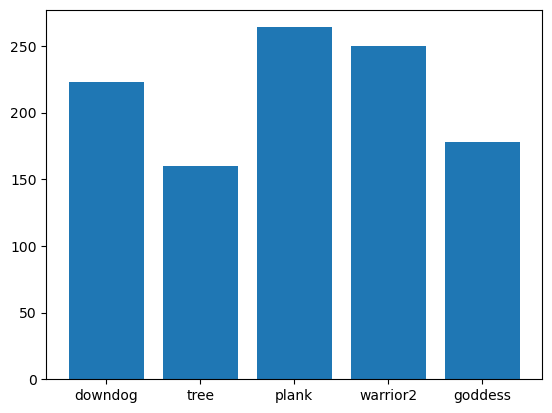

In [6]:
num_classes = list(df_test.labels.unique())
print(num_classes)
len(num_classes)
def data_count(main_path = '/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TRAIN'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in num_classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts
counts = data_count()
plt.bar(list(counts.keys()),list(counts.values()))
plt.show()

Consisting of 1,547 images split into 5 classes, or poses, this dataset is smaller and contains less poses than will be necessary for later phases of the project. However, for this initial phase, it contains enough images to investigate how different models will perform.

['downdog', 'tree', 'plank', 'warrior2', 'goddess']


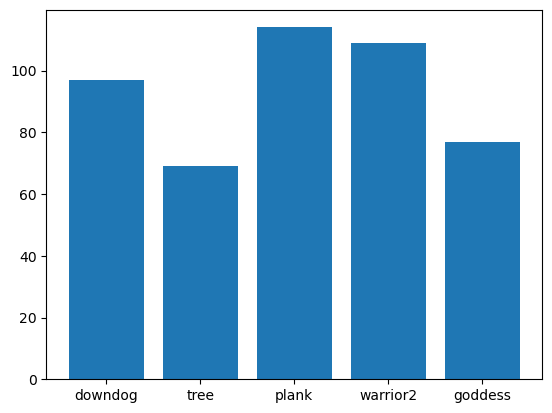

In [7]:
num_classes = list(df_test.labels.unique())
print(num_classes)
len(num_classes)
def data_count(main_path = '/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TEST'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in num_classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts
counts = data_count()
plt.bar(list(counts.keys()),list(counts.values()))
plt.show()

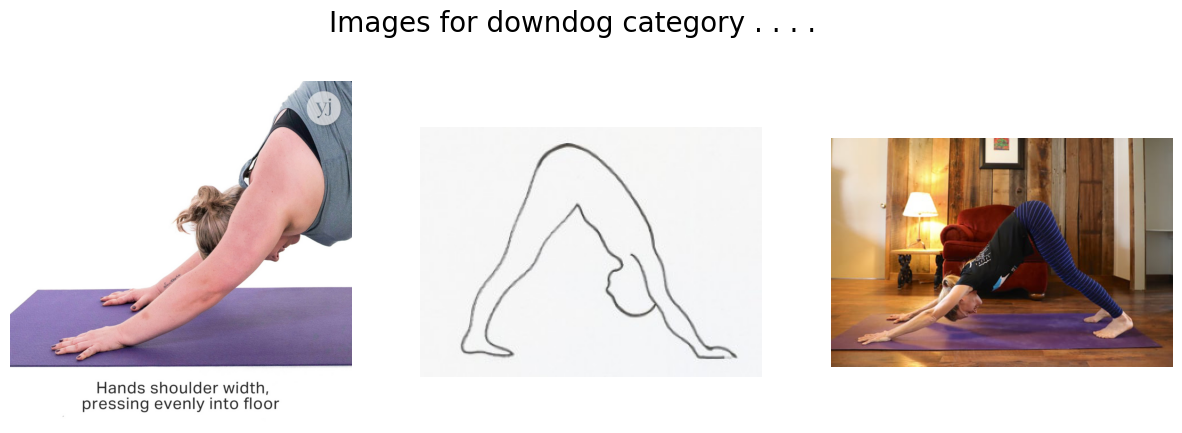

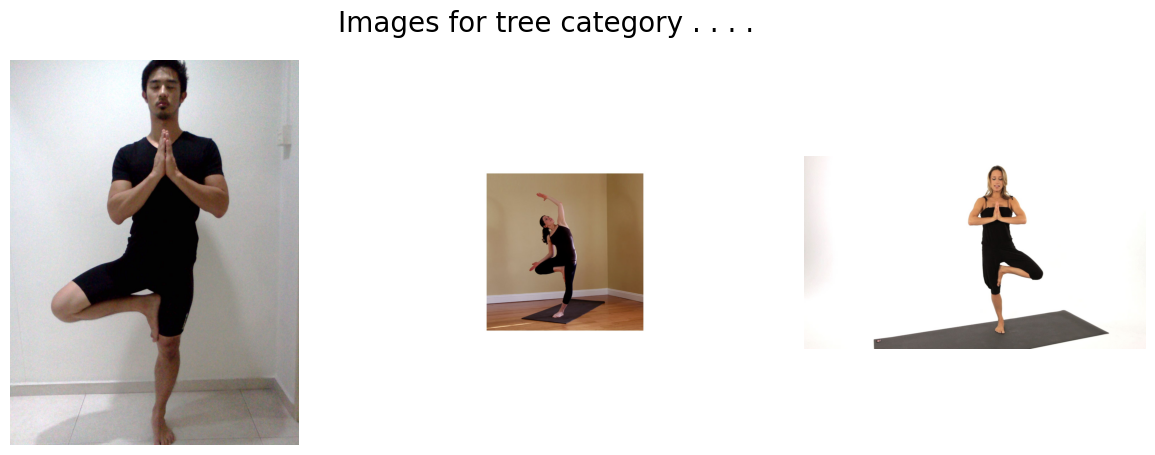

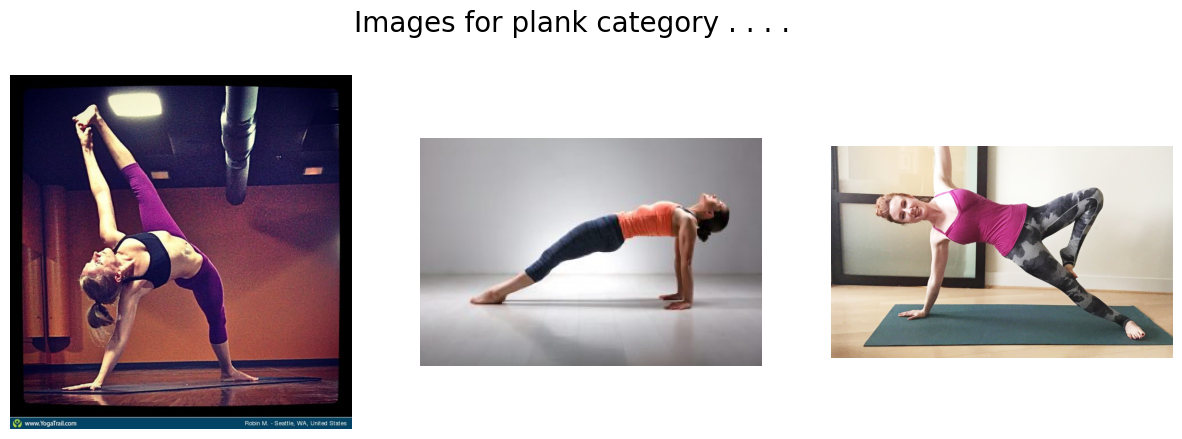

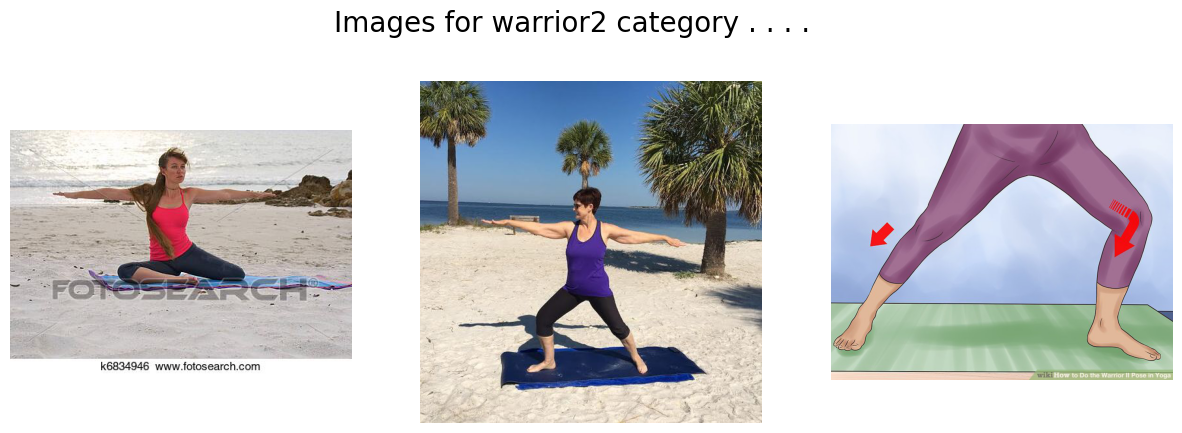

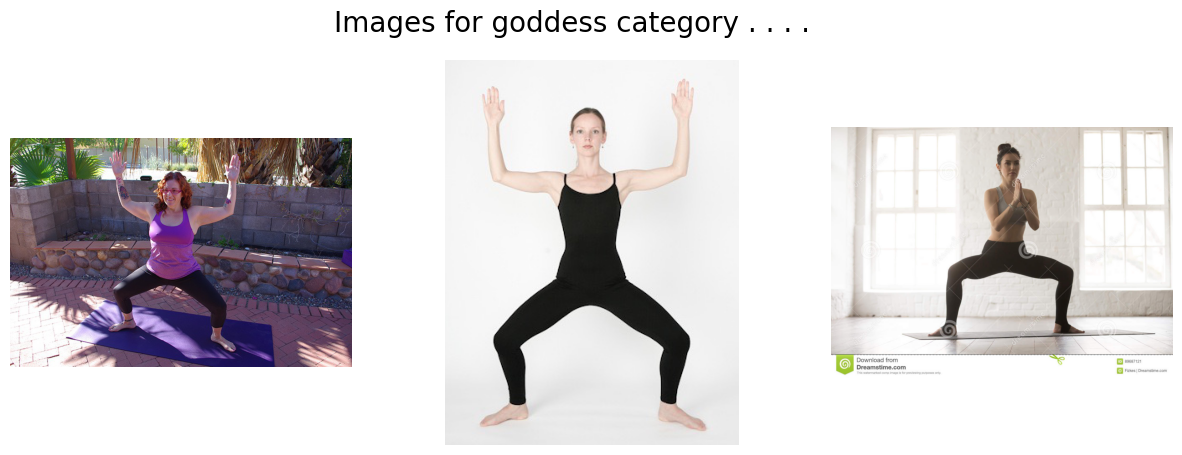

In [9]:
from PIL import Image

path = '/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TRAIN'
for cat in num_classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# 2-Data preprocessing

When training a convolutional neural network (CNN), it is common to split the dataset into three parts: training set, validation set, and test set

In [13]:
train_dir = '//kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TRAIN'
val_dir = '/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TRAIN'
test_dirr='/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TEST'

In [14]:
VAL_SPLIT = 0.20
IMAGE_SIZE = 256
IMAGE_CHAN = 3
BATCH_SIZE = 64
CLASSES = os.listdir(train_dir)
NUM_CLASSES = len(CLASSES)
EPOCHS = 30

In [15]:
train_gen = ImageDataGenerator(
                                rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.1,
                                fill_mode='nearest',
                                horizontal_flip=True,
                                validation_split=VAL_SPLIT
                                )

# Create Data Loaders for training and validation sets
train_generator = train_gen.flow_from_directory(
                                train_dir,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical',
                                subset='training')

val_generator = train_gen.flow_from_directory(
                                train_dir,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical',
                                subset='validation')

# Create Image Data Generator and Data Loader for test set

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
                                test_dirr,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical')

Found 862 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
Found 466 images belonging to 5 classes.


# 3-Data Modeling

## 3.1-Convolutional Neural Network (CNN) — Baseline

### 3.1.1 Model 1

A convolutional neural network is a class of deep learning methods that has become the most popular for computer vision tasks. It is composed of multiple convolution layers, pooling layers and fully connected layers. It uses a backpropogation algorithm to learn spatial hierarchies of features. So, let’s get started building a baseline CNN.

In [97]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

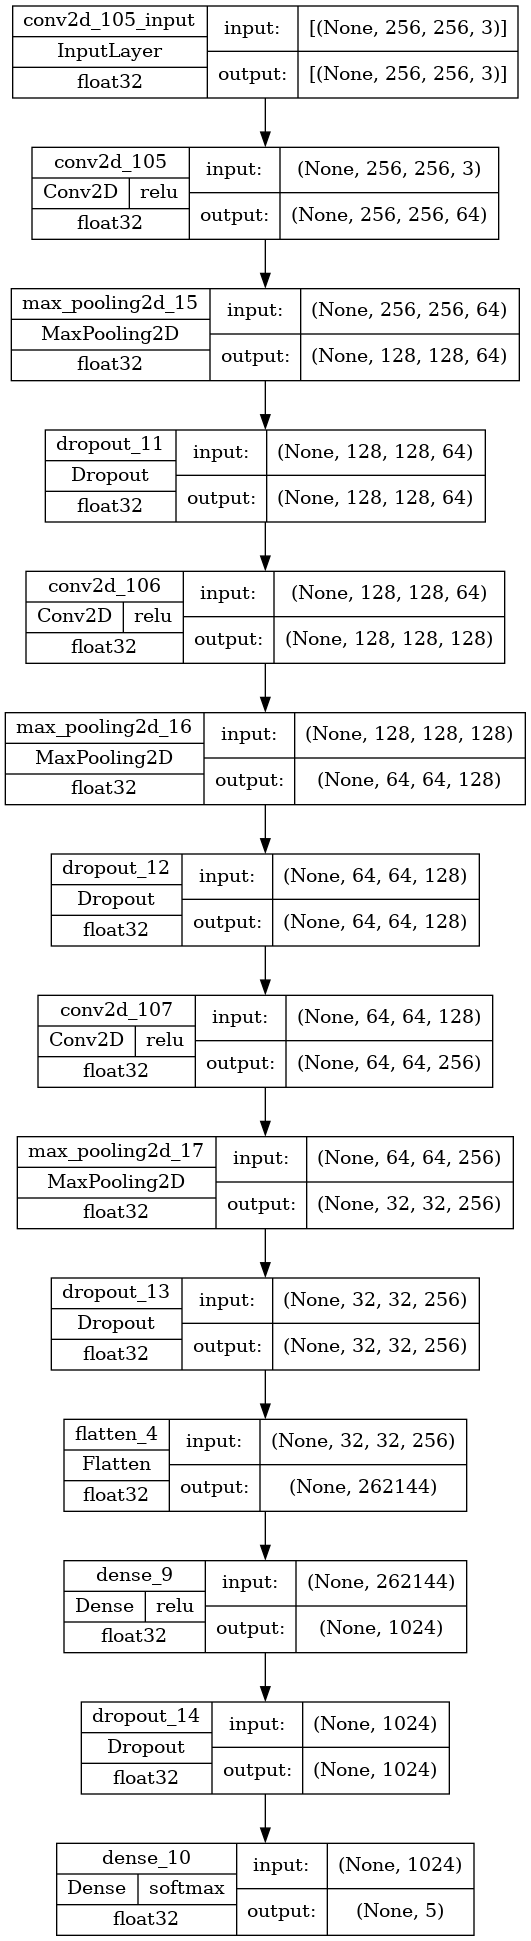

In [98]:
keras.utils.plot_model(
model2,
show_shapes = True,
show_dtype = True,
show_layer_activations = True
)


In [99]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

In [100]:
history1 = model2.fit(train_generator, epochs = 50,validation_data = val_generator)

Epoch 1/50


2023-04-17 09:44:36.553043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 36s 2s/step - loss: 6.6157 - accuracy: 0.2111 - val_loss: 1.5998 - val_accuracy: 0.2441
Epoch 2/50
14/14 [==============================] - 31s 2s/step - loss: 1.6063 - accuracy: 0.2332 - val_loss: 1.6059 - val_accuracy: 0.2441
Epoch 3/50
14/14 [==============================] - 31s 2s/step - loss: 1.5969 - accuracy: 0.2703 - val_loss: 1.5933 - val_accuracy: 0.2441
Epoch 4/50
14/14 [==============================] - 31s 2s/step - loss: 1.5879 - accuracy: 0.2668 - val_loss: 1.5439 - val_accuracy: 0.3052
Epoch 5/50
14/14 [==============================] - 31s 2s/step - loss: 1.5533 - accuracy: 0.3364 - val_loss: 1.4321 - val_accuracy: 0.4601
Epoch 6/50
14/14 [==============================] - 31s 2s/step - loss: 1.3921 - accuracy: 0.4594 - val_loss: 1.2586 - val_accuracy: 0.5164
Epoch 7/50
14/14 [==============================] - 31s 2s/step - loss: 1.3103 - accuracy: 0.5116 - val_loss: 1.2333 - val_accuracy: 0.5258
Epoch 8/50
14/14 [=============

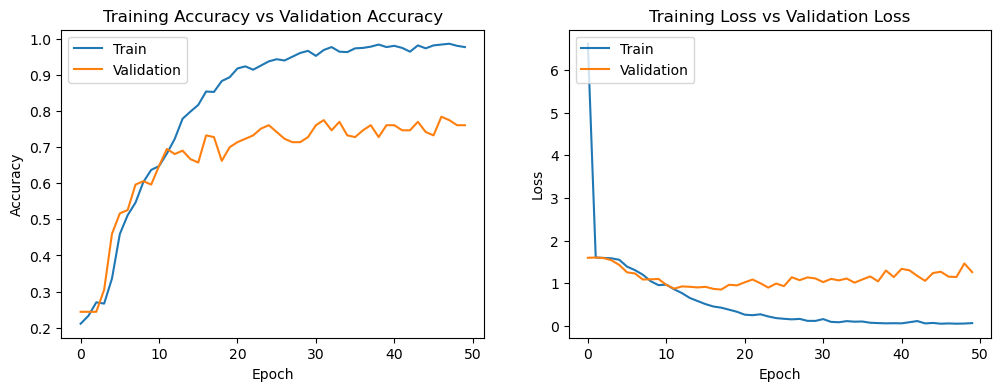

In [101]:
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history1.history['accuracy'])
ax[0].plot(history1.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history1.history['loss'])
ax[1].plot(history1.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [102]:
test_predict = model2.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 16s 2s/step - loss: 1.0488 - accuracy: 0.7961


In [104]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred1 = np.argmax(model2.predict(test_generator), axis=1)
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred1 = np.argmax(model2.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred1, target_names=CLASSES))
print(classification_report(Y_test, y_pred1, target_names=CLASSES))

8/8 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

     downdog       0.91      0.82      0.86        97
        tree       0.71      0.62      0.66        77
       plank       0.81      0.84      0.82       114
    warrior2       0.84      0.96      0.89        69
     goddess       0.72      0.74      0.73       109

    accuracy                           0.80       466
   macro avg       0.80      0.80      0.80       466
weighted avg       0.80      0.80      0.79       466

              precision    recall  f1-score   support

     downdog       0.91      0.82      0.86        97
        tree       0.71      0.62      0.66        77
       plank       0.81      0.84      0.82       114
    warrior2       0.84      0.96      0.89        69
     goddess       0.72      0.74      0.73       109

    accuracy                           0.80       466
   macro avg       0.80      0.80      0.80       466
weighted avg       0.80   

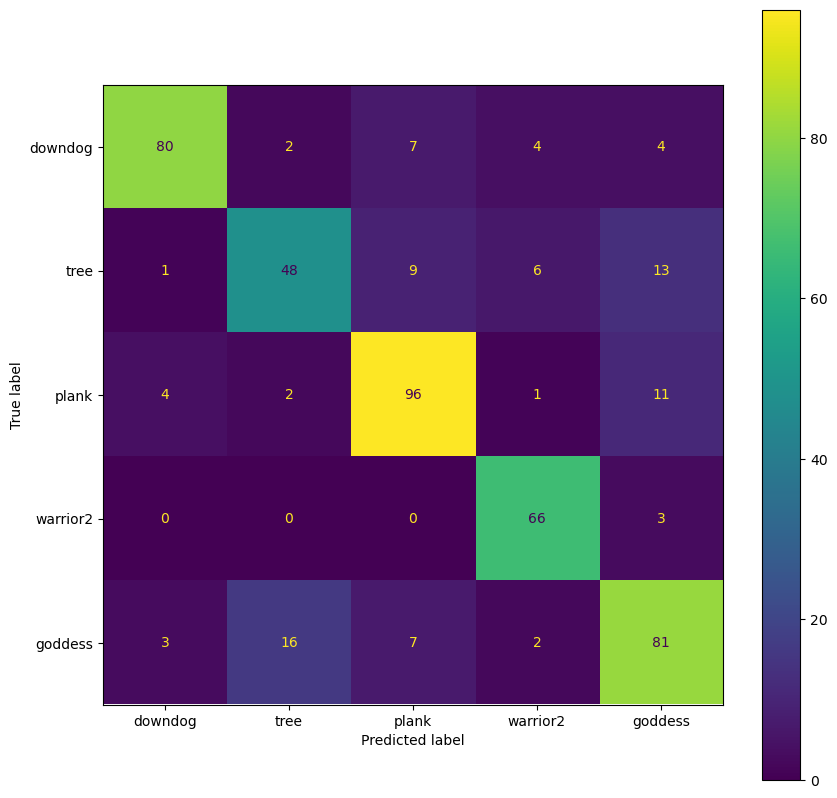

In [107]:

from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred1)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [108]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy:', accuracy)

Accuracy: 0.796137339055794


### 3.1.2 Model 2

**In order to enhance the model's performance, we incorporated two additional layers and implemented early stopping as a measure to prevent overfitting.**

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [17]:
class earlyStopAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            self.model.stop_training = True
            print('Reached 99% accuracy, stopping training.')

callbacks = earlyStopAcc()

In [18]:
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[callbacks])

Epoch 1/30
14/14 [==============================] - 44s 2s/step - loss: 1.6036 - accuracy: 0.2448 - val_loss: 1.5819 - val_accuracy: 0.3005
Epoch 2/30
14/14 [==============================] - 31s 2s/step - loss: 1.5693 - accuracy: 0.2981 - val_loss: 1.4633 - val_accuracy: 0.4038
Epoch 3/30
14/14 [==============================] - 31s 2s/step - loss: 1.4199 - accuracy: 0.4246 - val_loss: 1.2579 - val_accuracy: 0.5728
Epoch 4/30
14/14 [==============================] - 31s 2s/step - loss: 1.2807 - accuracy: 0.4791 - val_loss: 1.1407 - val_accuracy: 0.5869
Epoch 5/30
14/14 [==============================] - 31s 2s/step - loss: 1.1406 - accuracy: 0.5429 - val_loss: 0.9342 - val_accuracy: 0.6432
Epoch 6/30
14/14 [==============================] - 31s 2s/step - loss: 1.0218 - accuracy: 0.6079 - val_loss: 0.8473 - val_accuracy: 0.6573
Epoch 7/30
14/14 [==============================] - 31s 2s/step - loss: 0.8961 - accuracy: 0.6520 - val_loss: 0.7905 - val_accuracy: 0.7136
Epoch 8/30
14/14 [==

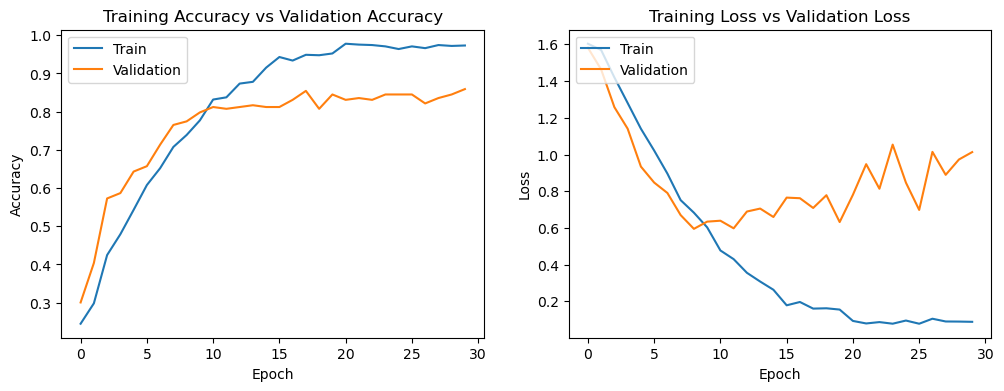

In [19]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [21]:
test_predict = model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 16s 2s/step - loss: 0.9583 - accuracy: 0.8734


In [ ]:
CLASSES = os.listdir(train_dir)


In [23]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred, target_names=CLASSES))

8/8 [==============================] - 13s 2s/step
              precision    recall  f1-score   support

     downdog       0.97      0.96      0.96        97
        tree       0.98      0.53      0.69        77
       plank       0.86      0.93      0.89       114
    warrior2       0.97      0.96      0.96        69
     goddess       0.74      0.93      0.82       109

    accuracy                           0.87       466
   macro avg       0.90      0.86      0.87       466
weighted avg       0.89      0.87      0.87       466



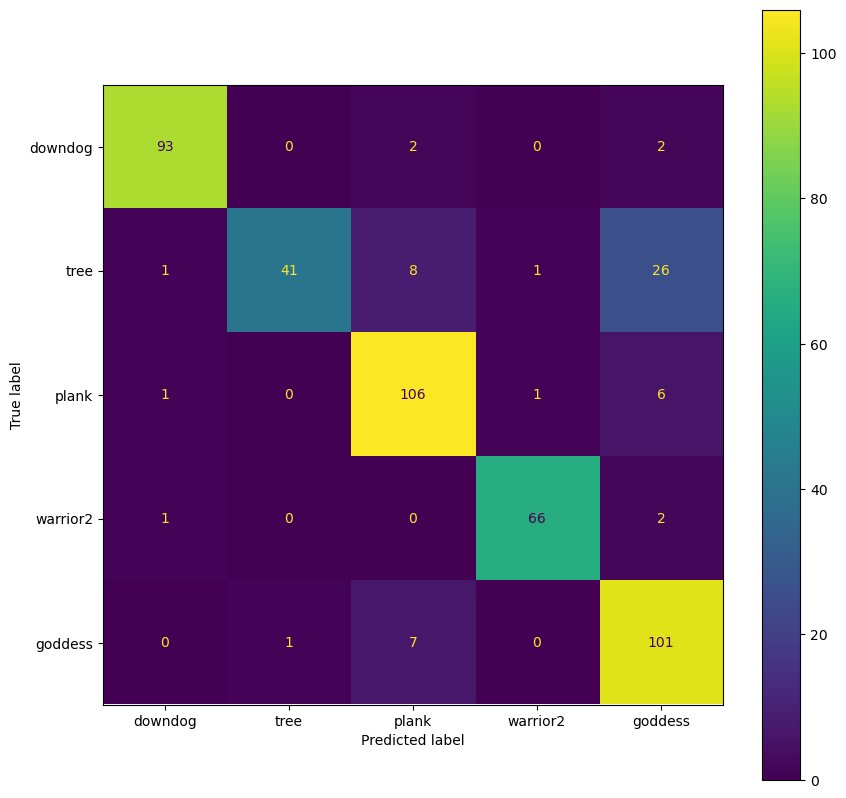

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [29]:
accuracy1 = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy:', accuracy1)

Accuracy: 0.8733905579399142


1/1 [==============================] - 0s 22ms/step
[[0. 1. 0. 0. 0.]]


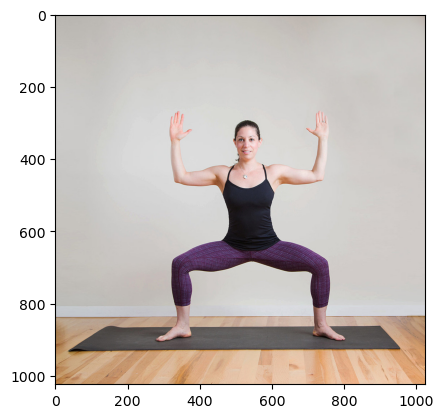

In [34]:
import matplotlib.pyplot as plot
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
img = load_img('/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TEST/goddess/00000000.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes)
img = Image.open('/kaggle/input/yogadata/YOGA/content/cleaned/DATASET/TEST/goddess/00000000.jpg')
img_array = np.array(img)

plt.imshow(img_array)
plt.show()

### 3.1.3 Transfer Learning


This next section will import an Inception model pre-trained on the famous ImageNet dataset. Taking advantage of all the features learned in that pre-training might produce a better classifier for this new task

In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model with imagenet weights

inception_model = InceptionV3(
                        input_shape =(IMAGE_SIZE, IMAGE_SIZE ,IMAGE_CHAN),
                        include_top = False,
                        weights='imagenet'
                        )

for layer in inception_model.layers:
    layer.trainable = False

last_layer = inception_model.get_layer('mixed7')
last_output = last_layer.output

87910968/87910968 [==============================] - 0s 0us/step


In [35]:
# Add new layers to perform classification on the new dataset with number of classes as the last layers outputs
model3 = tf.keras.layers.Flatten()(last_output)
model3 = tf.keras.layers.Dense(1024, activation='relu')(model3)
model3 = tf.keras.layers.Dropout(0.2)(model3)                  
model3 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(model3)           

pretrained_model = tf.keras.Model(inception_model.input, model3) 

pretrained_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [36]:
pretrained_hist = pretrained_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[callbacks])


Epoch 1/30
14/14 [==============================] - 39s 2s/step - loss: 15.7480 - accuracy: 0.4211 - val_loss: 2.1246 - val_accuracy: 0.6854
Epoch 2/30
14/14 [==============================] - 33s 2s/step - loss: 1.0866 - accuracy: 0.8167 - val_loss: 0.5321 - val_accuracy: 0.8732
Epoch 3/30
14/14 [==============================] - 31s 2s/step - loss: 0.3139 - accuracy: 0.9281 - val_loss: 0.3767 - val_accuracy: 0.8967
Epoch 4/30
14/14 [==============================] - 31s 2s/step - loss: 0.1342 - accuracy: 0.9582 - val_loss: 0.3124 - val_accuracy: 0.9296
Epoch 5/30
14/14 [==============================] - 31s 2s/step - loss: 0.0993 - accuracy: 0.9780 - val_loss: 0.2627 - val_accuracy: 0.9108
Epoch 6/30
14/14 [==============================] - 32s 2s/step - loss: 0.0633 - accuracy: 0.9814 - val_loss: 0.2505 - val_accuracy: 0.9343
Epoch 7/30
14/14 [==============================] - 31s 2s/step - loss: 0.0365 - accuracy: 0.9907 - val_loss: 0.1939 - val_accuracy: 0.9484


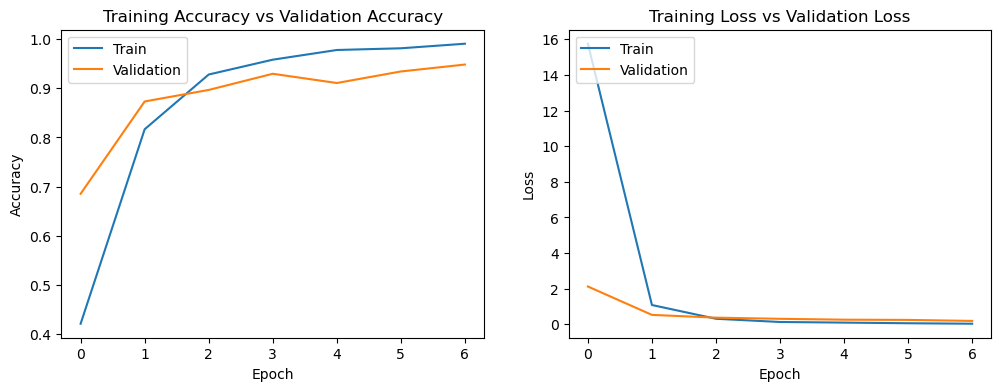

In [37]:
fig , ax = plt.subplots(1,2)
train_acc = pretrained_hist.history['accuracy']
train_loss = pretrained_hist.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(pretrained_hist.history['accuracy'])
ax[0].plot(pretrained_hist.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(pretrained_hist.history['loss'])
ax[1].plot(pretrained_hist.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [38]:
test_predict2 = pretrained_model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 14s 2s/step - loss: 0.1363 - accuracy: 0.9635


In [39]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred2 = np.argmax(pretrained_model.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred2, target_names=CLASSES))

8/8 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

     downdog       1.00      0.97      0.98        97
        tree       0.95      0.90      0.92        77
       plank       0.96      0.98      0.97       114
    warrior2       1.00      1.00      1.00        69
     goddess       0.93      0.96      0.95       109

    accuracy                           0.96       466
   macro avg       0.97      0.96      0.96       466
weighted avg       0.96      0.96      0.96       466



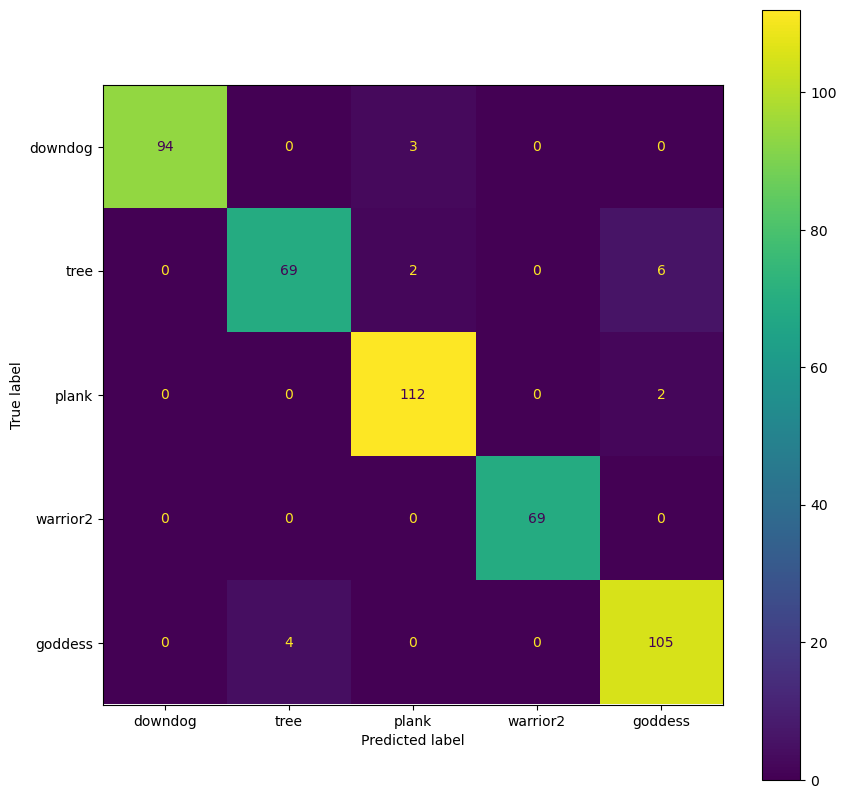

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred2)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [41]:
accuracy2 = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy:', accuracy2)

Accuracy: 0.9635193133047211


# 4-Data Evaluation


In [8]:
df

,Model,train_acc,val_acc,train_loss,val_loss,Predict_Acc
0,Model 1,0.97,0.76,0.0096,0.260,0.79
1,Model 2,0.97,0.85,0.0800,0.101,0.87
2,Model 3 : Transfer Learning,0.99,0.94,0.0030,0.190,0.96
